In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision.models import vit_b_16, ViT_B_16_Weights
import time

# Load MNIST dataset (grayscale, so we convert to 3-channel for ViT)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT needs 224x224 images
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Use only a **small subset** for fast training
train_dataset = Subset(train_dataset, range(1000))  # 1000 images for training
test_dataset = Subset(test_dataset, range(200))  # 200 images for testing

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Simple CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 112 * 112, 10)  # 10 classes (digits 0-9)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = self.fc1(x)
        return x

# Load pre-trained ViT model and fine-tune
vit_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 10)  # 10 output classes

# Fine-tune ViT
for param in vit_model.parameters():
    param.requires_grad = True

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN().to(device)
vit_model = vit_model.to(device)

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=0.0001)  # AdamW for ViT

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    total_time = time.time() - start_time
    print(f"Training Time: {total_time:.2f} seconds")
    return total_time

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    start_time = time.time()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    inference_time = time.time() - start_time
    accuracy = 100 * correct / total
    return accuracy, inference_time

# Train and evaluate CNN
print("\nTraining CNN...")
cnn_training_time = train_model(cnn_model, train_loader, criterion, cnn_optimizer)
cnn_accuracy, cnn_inference_time = evaluate_model(cnn_model, test_loader)
print(f"CNN Accuracy: {cnn_accuracy:.2f}%, Inference Time: {cnn_inference_time:.4f} seconds")

# Train and evaluate ViT
print("\nTraining ViT...")
vit_training_time = train_model(vit_model, train_loader, criterion, vit_optimizer)
vit_accuracy, vit_inference_time = evaluate_model(vit_model, test_loader)
print(f"ViT Accuracy: {vit_accuracy:.2f}%, Inference Time: {vit_inference_time:.4f} seconds")

# Print efficiency comparison
print("\nEfficiency Comparison:")
print(f"CNN - Training Time: {cnn_training_time:.2f}s, Inference Time: {cnn_inference_time:.4f}s, Accuracy: {cnn_accuracy:.2f}%")
print(f"ViT - Training Time: {vit_training_time:.2f}s, Inference Time: {vit_inference_time:.4f}s, Accuracy: {vit_accuracy:.2f}%")


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.43MB/s]



Training CNN...
Training Time: 13.20 seconds
CNN Accuracy: 72.00%, Inference Time: 1.8106 seconds

Training ViT...
Training Time: 1787.73 seconds
ViT Accuracy: 93.50%, Inference Time: 109.8286 seconds

Efficiency Comparison:
CNN - Training Time: 13.20s, Inference Time: 1.8106s, Accuracy: 72.00%
ViT - Training Time: 1787.73s, Inference Time: 109.8286s, Accuracy: 93.50%


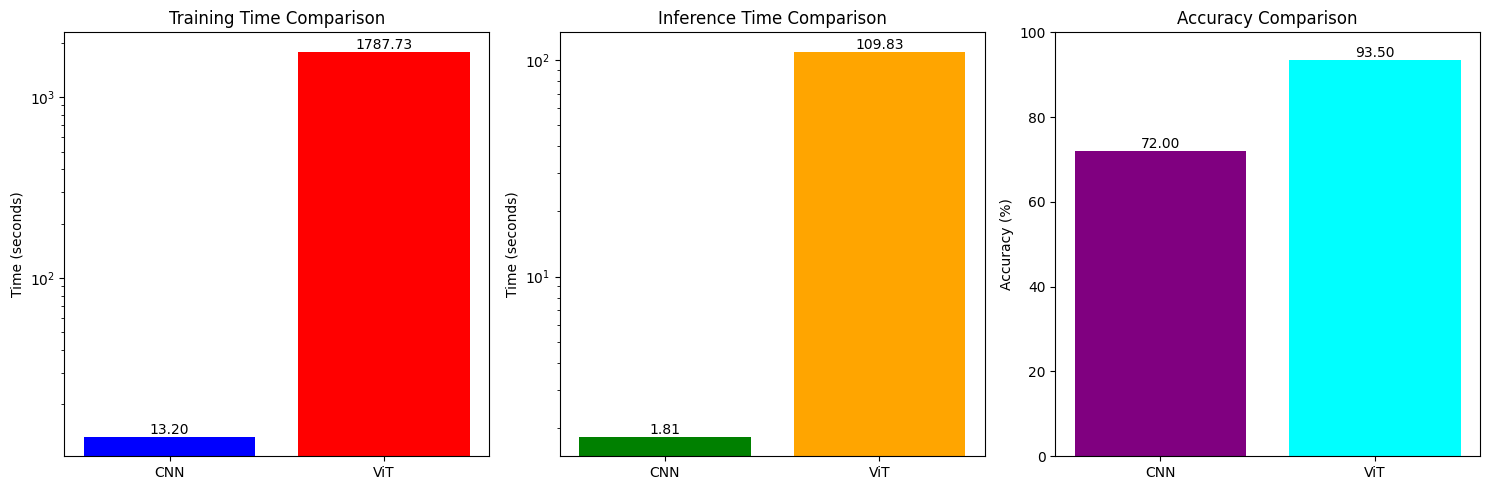

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your results
models = ['CNN', 'ViT']
training_times = [13.20, 1787.73]  # Training times in seconds
inference_times = [1.8106, 109.8286]  # Inference times in seconds
accuracies = [72.00, 93.50]  # Accuracy percentages

# Set width of bars
bar_width = 0.4
index = np.arange(len(models))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Training Time Bar Chart
axes[0].bar(models, training_times, color=['blue', 'red'])
axes[0].set_title("Training Time Comparison")
axes[0].set_ylabel("Time (seconds)")
axes[0].set_yscale('log')  # Log scale for better visibility
axes[0].bar_label(axes[0].containers[0], fmt="%.2f")

# Inference Time Bar Chart
axes[1].bar(models, inference_times, color=['green', 'orange'])
axes[1].set_title("Inference Time Comparison")
axes[1].set_ylabel("Time (seconds)")
axes[1].set_yscale('log')  # Log scale for better visibility
axes[1].bar_label(axes[1].containers[0], fmt="%.2f")

# Accuracy Bar Chart
axes[2].bar(models, accuracies, color=['purple', 'cyan'])
axes[2].set_title("Accuracy Comparison")
axes[2].set_ylabel("Accuracy (%)")
axes[2].set_ylim(0, 100)
axes[2].bar_label(axes[2].containers[0], fmt="%.2f")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
